# Computer Vision Models for CIFAR10

*PyTorch for Computer Vision*: This notebook trains some well-known convolutional neural networks designed for image recognition on the Food101 dataset.

TODO:
- Run comparitive analysis
- Plot convergence plots

In [ ]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor, Resize

# Import matplotlib for visualization
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import numpy as np


print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu121
0.16.0+cu121


In [ ]:
# Transformations to normalize the data and convert it to a PyTorch tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((227, 227))
])

# Load the CIFAR-10 dataset
train_data = datasets.Food101(root='./data', split='train', download=True, transform=transform)
test_data = datasets.Food101(root='./data', split='test', download=True, transform=transform)

print(f"Train samples: {len(train_data)}, Test samples: {len(test_data)}")

Train samples: 75750, Test samples: 25250


In [ ]:
# Device agnostic code

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 227, 227])
Number of classes: 101
Classes of the data: {'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheese_plate': 16, 'cheesecake': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34, 'escargots': 35, 'falafel': 36, 'filet_mignon': 37, 'fish_and_chips': 38, 'foie_gras': 39, 'french_fries': 40, 'french_onion_soup': 41, 'french_toast': 42, 'fried_calamari': 43, 'fried_rice': 44, 'frozen_yogurt': 45, 'garlic_bread': 46, 'gnocchi': 47, 'greek_salad': 4

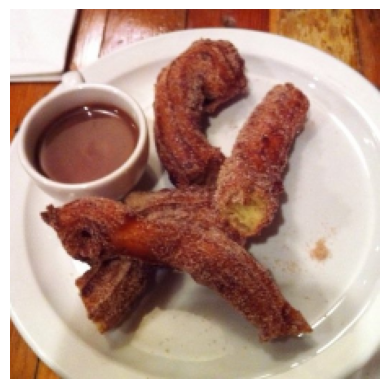

In [ ]:
# Take the first image from the batch
image, label = train_data[0]
print(image.shape)

classes = train_data.classes
class_to_idx = train_data.class_to_idx
print(f"Number of classes: {len(classes)}")
print(f"Classes of the data: {class_to_idx}")
print(f"Shape of 0th training sample (Channels, Width, Height): {image.shape}")
print(f"Class of the 0th training sample: {classes[label]}")

N_CLASSES = len(classes)

# Display the RGB image using matplotlib
plt.imshow(image.permute(1, 2, 0)) # See https://stackoverflow.com/questions/53623472/how-do-i-display-a-single-image-in-pytorch
plt.axis('off')  # Turn off axis labels
plt.show()

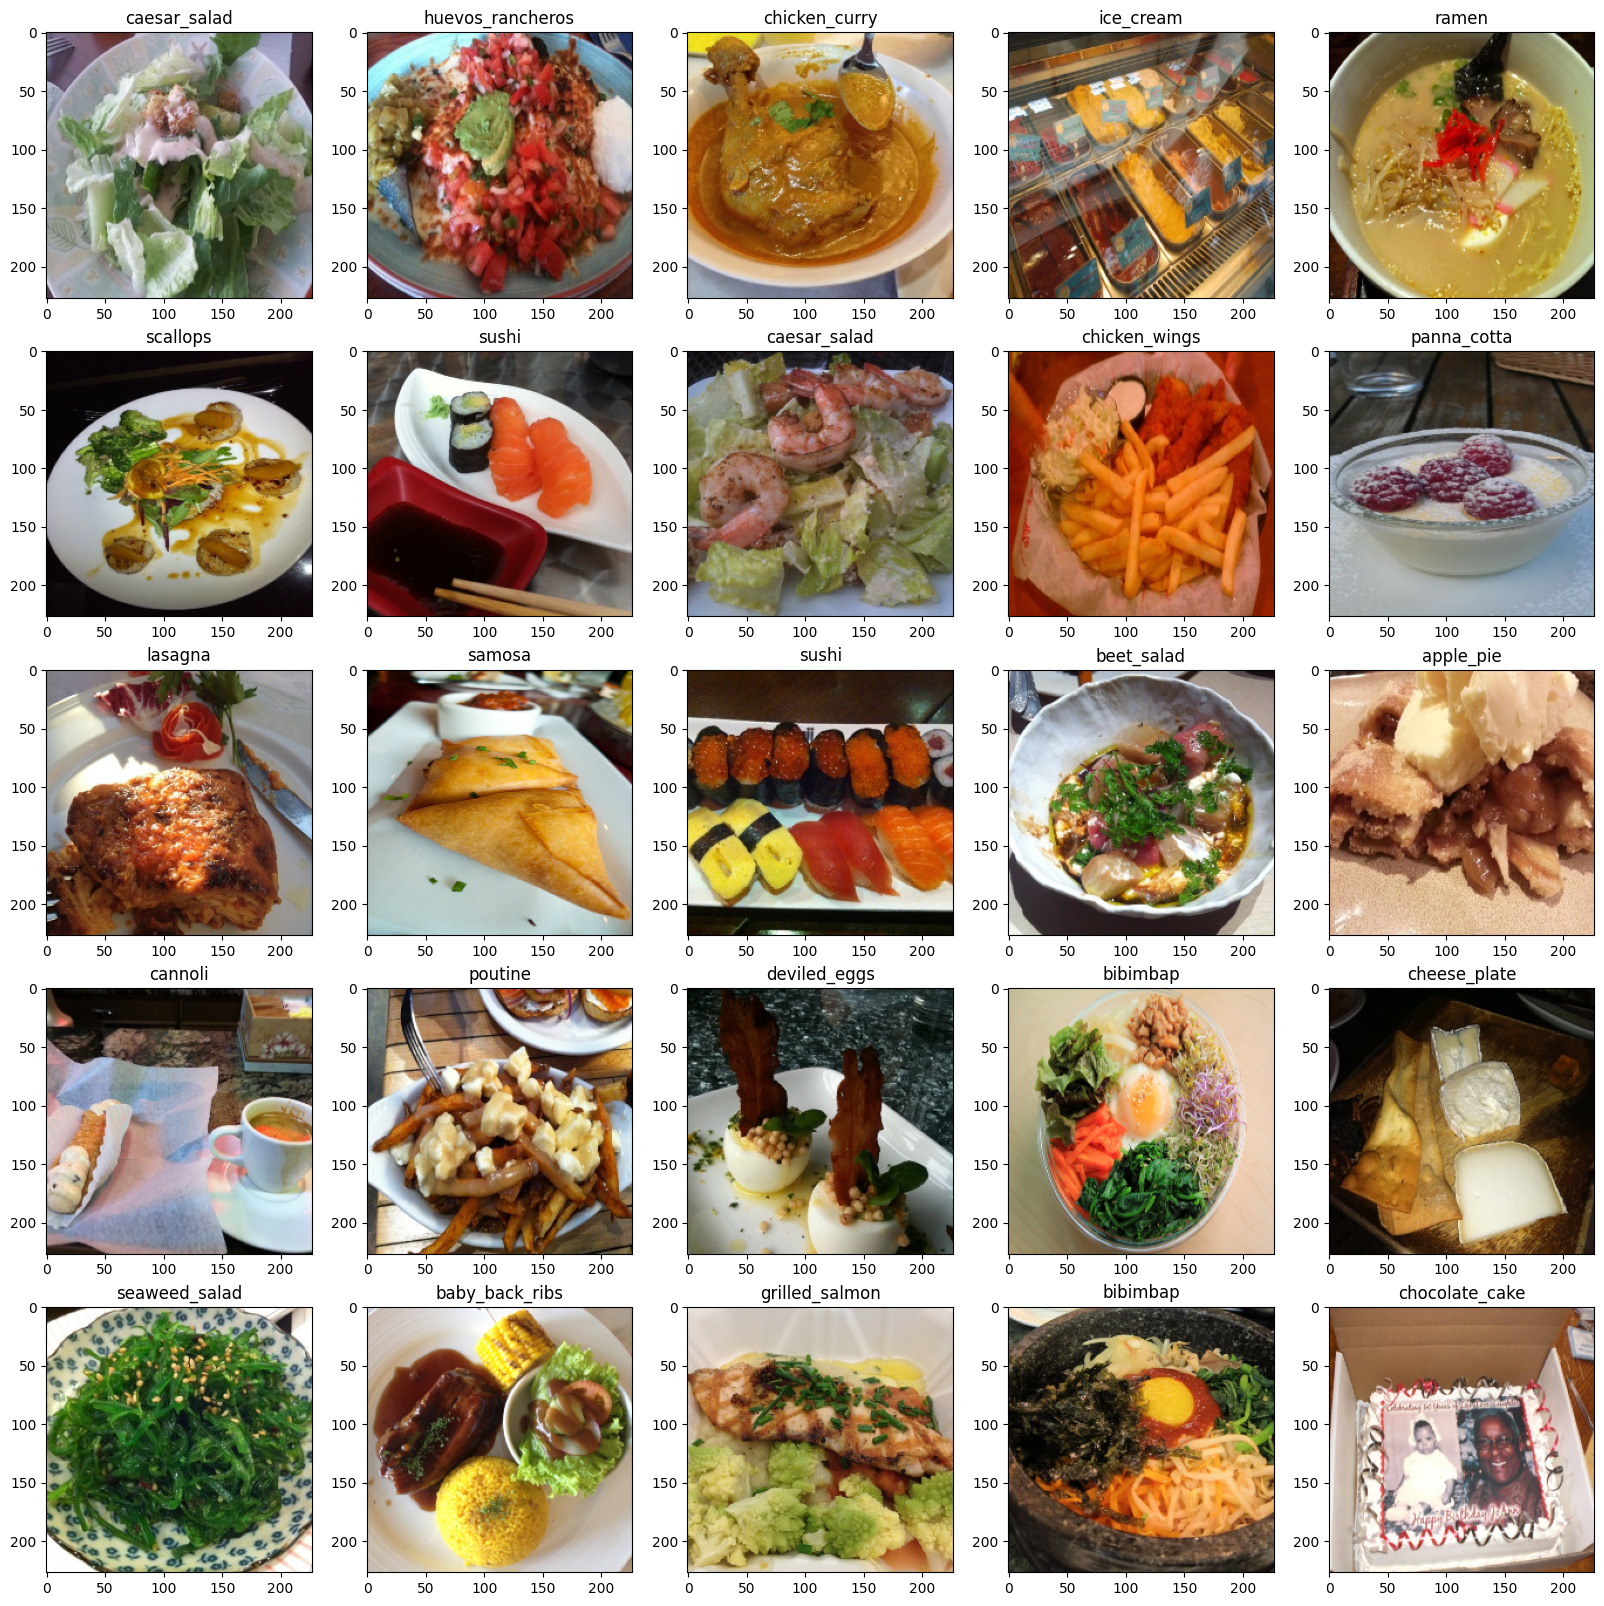

In [ ]:
# Plot more images
fig = plt.figure(figsize=(20, 20))
rows, cols = 5, 5
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.permute(1, 2, 0))
  plt.title(classes[label])

## Prepare DataLoaders

Our data is in PyTorch datasets form. We should turn this data into batches (for instance, 32 images at a time) as it is computationally efficient. It also gives our neural network more chances to update its gradients per epoch.

In [ ]:
train_data, test_data

In [ ]:
from torch.utils.data import DataLoader

# Set batch size
BATCH_SIZE = 32

# Turn dataset into iterables
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

> Samples of X are in the shape of (batch size, channels, width, height)

## Create Model Classes

In [ ]:
import torch
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, num_classes=101):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Example usage:
modelAlex = AlexNet(N_CLASSES)  # Food101 has 101 classes
print(modelAlex)

In [ ]:
# VGG16 Model

class VGG16(nn.Module):
  def __init__(self,
               n_classes):
    super().__init__()

    filter_map = [3, 64, 128, 256, 512]

    self.block1 = self._make_2_conv_blocks(filter_map[0], filter_map[1])
    self.block2 = self._make_2_conv_blocks(filter_map[1], filter_map[2])
    self.block3 = self._make_3_conv_blocks(filter_map[2], filter_map[3])
    self.block4 = self._make_3_conv_blocks(filter_map[3], filter_map[4])
    self.block5 = self._make_3_conv_blocks(filter_map[4], filter_map[4])
    self.avgpool = nn.AdaptiveAvgPool2d((7, 7)) # see explanation below
    self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096), # see explanation below
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, n_classes),
          )

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1) # see explanation below
    x = self.classifier(x)
    return x

  def _make_2_conv_blocks(self, in_channels, hidden_filters):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels,
                  out_channels=hidden_filters,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_filters),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_filters,
                  out_channels=hidden_filters,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_filters),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
    )

  def _make_3_conv_blocks(self, in_channels, hidden_filters):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels,
                  out_channels=hidden_filters,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_filters),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_filters,
                  out_channels=hidden_filters,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_filters),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_filters,
                  out_channels=hidden_filters,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_filters),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
    )

modelVGG16 = VGG16(N_CLASSES).to(device)
print(modelVGG16)

## Loss, Optimizer and Evaluation Metrics

- `nn.CrossEntropyLoss` for multiclass data
- `torchmetrics.Accuracy` for balanced class classification
- `torch.optim.SGD` as the optimizer

In [ ]:
# Import timer to time executions
from timeit import default_timer as timer

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

## Training and Testing Loops

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        acc = accuracy_fn(y_true=y,
                          y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels
        train_loss += loss
        train_acc += acc

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        print(f"Batch {batch} | Train loss: {loss} | Train acc: {acc}")

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [ ]:
# Measure time
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [1]:
def train_one_model(model, epochs, lr):
  torch.manual_seed(42)
  # Setup loss and optimizer
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(params=model.parameters(),
                              lr=lr, momentum=0.8)

  train_time_start_model = timer()

  # Train and test model
  for epoch in tqdm(range(epochs)):
      print(f"Epoch: {epoch}\n---------")
      train_step(data_loader=train_dataloader,
          model=model,
          loss_fn=loss_fn,
          optimizer=optimizer,
          accuracy_fn=accuracy_fn,
          device=device
      )
      test_step(data_loader=test_dataloader,
          model=modelVGG16,
          loss_fn=loss_fn,
          accuracy_fn=accuracy_fn,
          device=device
      )

  train_time_end_model = timer()
  total_train_time_model = print_train_time(start=train_time_start_model,
                                            end=train_time_end_model,
                                            device=device)

  torch.manual_seed(42)

  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y, y_pred.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_loss": loss.item(),
          "model_acc": acc,
          "model_train_time": total_train_time_model}

In [ ]:
models_list = [modelAlex, modelVGG16]

for m in models_list:
  print(f"Training model {m.__class__.__name__}...")
  results = train_one_model(model=m, epochs=3, lr=0.1)
  print(results)